In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
!pwd
os.chdir('/content/gdrive/MyDrive/cv')
!pwd

/content
/content/gdrive/MyDrive/cv


# Libraries

In [4]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as torchFunc
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from torchsummary import summary

import os
import numpy as np
from xml.etree import ElementTree
from skimage import io
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.auto import tqdm

# __Face Augmentation__

In [ ]:
class AugFace:
  def __init__(self, dim, bright, contrast, saturation, hue, face_offset, crop_offset):
    self.face_offset = face_offset
    self.dim = dim
    self.crop_offset = crop_offset
    self.transform = transforms.ColorJitter(bright, contrast, saturation, hue)

  def img_crop_offset(self, img, landmarks, crop_coord):
    l = int(crop_coord['left']) - self.face_offset
    t = int(crop_coord['top']) - self.face_offset
    w = int(crop_coord['width']) + (2 * self.face_offset)
    h = int(crop_coord['height']) + (2*self.face_offset)

    img = torchFunc.crop(img, t, l, h,w)
    landmarks = landmarks - np.array([[l, t]])

    new_dimen = self.dim + self.crop_offset

    img = torchFunc.resize(img, (new_dimen, new_dimen))
    
    landmarks[:, 0] *= new_dimen/w
    landmarks[:, 1] *= new_dimen/h

    return img, landmarks

  def img_random_face_crop(self, img, landmarks):
    img = np.array(img)
    h, w = img.shape[:2]
    t = np.random.randint(0, h-self.dim)
    l = np.random.randint(0, w - self.dim)

    img = img[t: t + self.dim, l: l+self.dim]
    landmarks = landmarks - np.array([[l, t]])

    return torchFunc.to_pil_image(img), landmarks

  def __call__(self, img, landmarks, crop_coord):
    img, landmarks = self.img_crop_offset(img, landmarks, crop_coord)
    img, landmarks = self.img_random_face_crop(img, landmarks)
    return img, landmarks

# Landmarks Augmentation

In [ ]:
class AugLandmarks:
  def __init__(self, dim, angle):
    # self.rot_limit = rotation_limit
    self.dim = dim
    self.angle = angle
  
  def rotate_random(self, img, landmarks):
    # angle = np.random.uniform(-self.rot_limit, self.rot_limit)
    angle = self.angle
    transform_landmarks_factor = np.array([[+np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                                    [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]])
    image = torchFunc.rotate(img, angle)
    landmarks = landmarks - 0.5
    trans_landmarks = np.matmul(landmarks, transform_landmarks_factor)
    trans_landmarks = trans_landmarks + 0.5

    return img,trans_landmarks

  def __call__(self, img, landmarks):
    img, landmarks = self.rotate_random(img, landmarks)
    return img, landmarks

# Data Preprocessing

In [ ]:
class DataAugPreprocessor:
  def __init__(self, dim, bright, contrast, saturation, hue, angle, face_offset, crop_offset):
    self.dim = dim
    self.landmarks_aug = AugLandmarks(dim, angle)
    self.face_aug = AugFace(dim, bright, contrast, saturation, hue, face_offset, crop_offset)
  
  def __call__(self, img, landmarks, crop_coord):
    img = torchFunc.to_pil_image(img)
    img, landmarks = self.face_aug(img, landmarks, crop_coord)
    landmarks = landmarks / np.array([*img.size])
    img, landmarks = self.landmarks_aug(img, landmarks)
    img = torchFunc.to_grayscale(img)
    img = torchFunc.to_tensor(img)
    img = (img - img.min())/(img.max()-img.min())
    img = (2*img)-1

    return img, torch.FloatTensor(landmarks.reshape(-1)-0.5)

# Create the dataset class

In [ ]:
class DatasetLandmarks(Dataset):
  def __init__(self, augProcessor, train):
    self.root_dir = 'ibug_300W_large_face_landmark_dataset'
    self.img_paths = []
    self.landmarks = []
    self.crops = []
    self.augProcessor = augProcessor
    self.train = train

    elementTree = ElementTree.parse(os.path.join(self.root_dir, f'labels_ibug_300W_{"train" if train else "test"}.xml'))
    root = elementTree.getroot()

    for name in root[2]:
      self.img_paths.append(os.path.join(self.root_dir, name.attrib['file']))
      self.crops.append(name[0].attrib)
      landmark = []
      for mark_num in range(68):
        x = int(name[0][mark_num].attrib['x'])
        y = int(name[0][mark_num].attrib['y'])
        landmark.append([x, y])
      self.landmarks.append(landmark)

    self.landmarks = np.array(self.landmarks).astype('float32')
    assert len(self.img_paths) == len(self.landmarks)
    
  def __len__(self):
    return len(self.img_paths)
    
  def __getitem__(self, index):
    img = io.imread(self.img_paths[index], as_gray=False)
    landmarks = self.landmarks[index]

    img, landmarks = self.augProcessor(img, landmarks, self.crops[index])
    return img, landmarks

# Visualisation

In [ ]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (5, 5))
    image = (image - image.min())/(image.max() - image.min())

    landmarks = landmarks.view(-1, 2)
    landmarks = (landmarks + 0.5) * augProcessor.dim

    plt.imshow(image[0], cmap = 'gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 25, c = 'dodgerblue')
    plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        image = (image - image.min())/(image.max() - image.min())

        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5) * augProcessor.dim
        landmarks = landmarks.numpy().tolist()
        landmarks = np.array([(x, y) for (x, y) in landmarks if 0 <= x <= augProcessor.dim and 0 <= y <= augProcessor.dim])

        ax.imshow(image[0], cmap = 'gray')
        ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

# Initialise preprocessor, train and test img

In [ ]:
augProcessor = DataAugPreprocessor(
    dim = 128, 
    bright = 0.24,
    saturation = 0.3,
    contrast = 0.15,
    hue = 0.14,
    angle = 14,
    face_offset = 32,
    crop_offset = 16
)

train_imgs = DatasetLandmarks(augProcessor, train=True)
test_imgs = DatasetLandmarks(augProcessor, train=False)

# __Visualizing a sample image, with random augmentations__

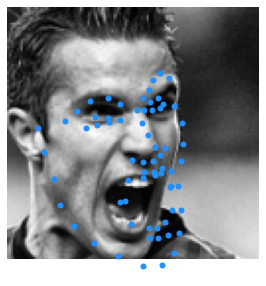

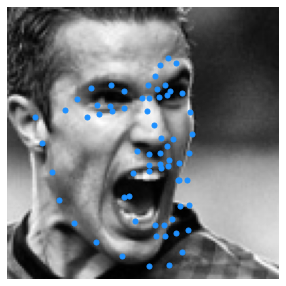

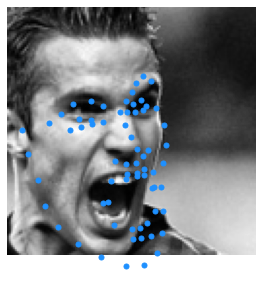

In [ ]:
image1, landmarks1 = train_imgs[36]
visualize_image(image1, landmarks1)

image2, landmarks2 = train_imgs[36]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_imgs[36]
visualize_image(image3, landmarks3)

# Prepare Data for training and visulise intermediate

In [ ]:
len_val = int(0.1*len(train_imgs))
len_train = len(train_imgs) - len_val

print(f'{len_train} images for training')
print(f'{len_val} images for validating')
print(f'{len(test_imgs)} images for testing')

train_imgs, val_imgs = random_split(train_imgs, [len_train, len_val])

batch_size = 32
train_data = DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_imgs, batch_size=2*batch_size, shuffle=False)
val_data = torch.utils.data.DataLoader(val_imgs, batch_size=2*batch_size, shuffle=False)

6000 images for training
666 images for validating
1008 images for testing


In [ ]:
type(train_data)

torch.utils.data.dataloader.DataLoader

In [ ]:
for x, y in train_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in val_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in test_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

torch.Size([32, 1, 128, 128]) torch.Size([32, 136]) tensor(1.) tensor(-1.) tensor(0.7737) tensor(-0.6794)
torch.Size([64, 1, 128, 128]) torch.Size([64, 136]) tensor(1.) tensor(-1.) tensor(0.7118) tensor(-0.7841)
torch.Size([64, 1, 128, 128]) torch.Size([64, 136]) tensor(1.) tensor(-1.) tensor(0.8470) tensor(-0.7040)


Training Batch Samples


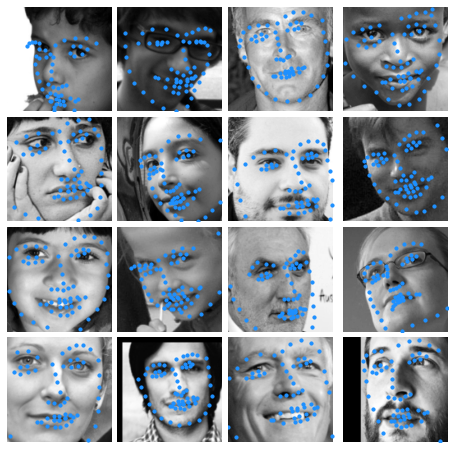

In [ ]:
visualize_batch(x[:16], y[:16], shape = (4, 4), size = 8, title = 'Training Batch Samples')

# Xception Net Model construction

In [9]:
class DepthwiseSepConv2D(nn.Module):
  def __init__(self, input_channels, output_channels, k_size, **kwargs):
    super(DepthwiseSepConv2D, self).__init__()

    self.depthwise = nn.Conv2d(input_channels, input_channels, k_size, groups=input_channels, bias=False, **kwargs)
    self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias=False)
  
  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)

    return x

In [10]:
class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

In [11]:
class EntryModule(nn.Module):
  def __init__(self):
    super(EntryModule, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 3, padding=1, bias=False), 
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )

    self.conv3_residual = nn.Sequential(
        DepthwiseSepConv2D(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        DepthwiseSepConv2D(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(3, stride=2, padding=1),
    )
    
    self.conv3_direct = nn.Sequential(
        nn.Conv2d(64, 128, 1, stride=2),
        nn.BatchNorm2d(128)
    )
    self.conv4_residual = nn.Sequential(
        nn.LeakyReLU(0.2),
        DepthwiseSepConv2D(128, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        DepthwiseSepConv2D(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2, padding=1)
    )

    self.conv4_direct = nn.Sequential(
        nn.Conv2d(128, 256, 1, stride=2),
        nn.BatchNorm2d(256),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    residual = self.conv3_residual(x)
    direct = self.conv3_direct(x)
    x = residual + direct

    residual = self.conv4_residual(x)
    direct = self.conv4_direct(x)
    x = residual + direct

    return x

In [12]:
class MiddleBlockBasicModule(nn.Module):
    def __init__(self):
        super(MiddleBlockBasicModule, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlockModule(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()
        self.block = nn.Sequential(*[MiddleBlockBasicModule() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)
        return x

In [13]:
class ExitBlockModule(nn.Module):
    def __init__(self):
        super(ExitBlockModule, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthwiseSepConv2D(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthwiseSepConv2D(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

# Xception Net Module

In [14]:
class XceptionNetModule(nn.Module):
  def __init__(self, num_middle_block=6):
    super(XceptionNetModule, self).__init__()

    self.entry_block = EntryModule()
    self.middel_block = MiddleBlockModule(num_middle_block)
    self.exit_block = ExitBlockModule()

    self.fc = nn.Linear(1024, 136)

  def forward(self, x):
    x = self.entry_block(x)
    x = self.middel_block(x)
    x = self.exit_block(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [15]:
xModel = XceptionNetModule()
xModel.cuda()
summary(xModel, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             288
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,432
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]             576
            Conv2d-8         [-1, 64, 128, 128]           4,096
DepthwiseSepConv2D-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
        LeakyReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]             576
           Conv2d-13        [-1, 128, 128, 128]           8,192
DepthwiseSepConv2D-14        [-1, 128, 

In [ ]:
!nvidia-smi

Sun May 23 00:54:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |   1269MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Define Optimizer and loss

In [22]:
objectiveFun = nn.MSELoss()
optimiser = optim.Adam(xModel.parameters(), lr=0.008)

# Define Validation

In [6]:
@torch.no_grad()
def validate_train(saveFlag=None):
  cumulative_loss = 0.0
  xModel.eval()

  for f, labels in tqdm(val_data, desc='Validating', ncols=600):
    f = f.cuda()
    labels = labels.cuda()
    out = xModel(f)
    loss = objectiveFun(out, labels)
    cumulative_loss += loss.item()
    break
  visualize_batch(f[:16].cpu(), out[:16].cpu(), shape = (4, 4), size = 16, title = 'Validation sample predictions', save = saveFlag)
  return cumulative_loss/len(val_data)

# validate_train()

### Store model's progress

In [7]:
!pwd
if os.path.isdir('model_progress'):
  !rm -rf model_progress
os.mkdir('model_progress')

/content/gdrive/My Drive/cv


# TRAINNNNNN

In [ ]:
epochs = 30
batches = len(train_data)
op_loss = np.inf
optimiser.zero_grad()

loss_vals = []

for epoch in range(epochs):
  cumulative_loss = 0.0
  epoch_loss= []

  xModel.train()
  for batch_ind, (f, labels) in enumerate(tqdm(train_data, desc=f'Epoch({epoch+1}/{epochs})', ncols=800)):
    f = f.cuda()
    labels = labels.cuda()

    out = xModel(f)
    loss = objectiveFun(out, labels)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    cumulative_loss += loss.item()
    epoch_loss.append(loss.item())

  loss_vals.append(sum(epoch_loss)/len(epoch_loss))

  validation_loss = validate(os.path.join('progress', f'epoch({str(epoch+1).zfill(len(str(epochs)))})'.jpg))
  if validation_loss < op_loss:
    op_loss = validation_loss
    print('Saving the very nice model')
    torch.save(model.state_dict(), 'face_landmark_model.pt')
  print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cumulative_loss/batches:.8f} | Validation Loss: {validation_loss:.8f}')  

KeyboardInterrupt: ignored

In [ ]:
epochs = 30
batches = len(train_data)
best_loss = np.inf
optimiser.zero_grad()

for epoch in range(epochs):
    cum_loss = 0.0

    xModel.train()
    for batch_index, (features, labels) in enumerate(tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = 800)):
        features = features.cuda()
        labels = labels.cuda()

        outputs = xModel(features)
        
        loss = objectiveFun(outputs, labels)

        loss.backward()

        optimiser.step()
        
        optimiser.zero_grad()

        cum_loss += loss.item()

    val_loss = validate(os.path.join('progress', f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        torch.save(xModel.state_dict(), 'face_landmark_model.pt')

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

NameError: ignored

# INFERENCE

In [16]:
xModel.load_state_dict(torch.load('/content/gdrive/MyDrive/cv/Facial-Landmarks-Detection-Pytorch/model.pt'))

<All keys matched successfully>

In [103]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2021-05-23 15:24:15--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  24.6MB/s    in 2.5s    

2021-05-23 15:24:18 (24.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [114]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("/content/gdrive/MyDrive/cv/Facial-Landmarks-Detection-Pytorch/shape_predictor_68_face_landmarks.dat")

In [152]:
def inference(path): 
  img = dlib.load_rgb_image(path)
  gray_out = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  faces = face_detector(img, 1)
  marks = []

  for k, d in enumerate(faces):
    points_landmark = landmark_detector(img, d)
    for n in range(0, 67):
        x = points_landmark.part(n).x
        y = points_landmark.part(n).y
        marks.append((x, y))
        cv2.circle(img, (x, y), 5, (255, 255, 0), -1)

  plt.imshow(img)
  plt.show()
  # return marks

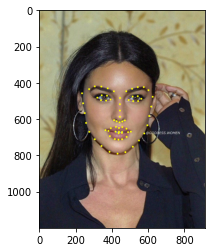

In [153]:
path = "/content/gdrive/MyDrive/cv/Facial-Landmarks-Detection-Pytorch/monica_bellucci.png"

inference(path)

In [ ]:
!nvidia-smi

Sun May 23 09:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   1293MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# INFERENCE

In [91]:
import dlib
from imutils import resize, face_utils
import cv2

In [143]:
def prep_img(img):
  img = torchFunc.to_pil_image(img)
  img = torchFunc.resize(img, (128, 128))
  img = torchFunc.to_tensor(img)
  img = (img - img.min())/(img.max()-img.min())
  img = (2*img)-1
  return img.unsqueeze(0)

def draw_facial_landmarks(img, landmarks):
  img = cv2.resize(img, (128, 128)) 

  img = img.copy()
  for landmarks, (l,t,h,w) in landmarks:
    landmarks = landmarks.view(-1,2)
    landmarks = landmarks+0.5
    landmarks = landmarks.numpy()

    for i, (x,y) in enumerate(landmarks, 1):
      try:
        # cv2.circle(img, (int((x * w) + l), int((y * h) + t)), 5, (255, 255, 0), -1)
        # cv2.circle(img, x,y , 5, (255, 255, 0), -1)
        
        cv2.circle(img, (int((x * w) + l), int((y * h) + t)), 5, [40, 117, 255], -1)
      except:
        pass
  return img

In [150]:
detector = dlib.get_frontal_face_detector()

@torch.no_grad()
def inference_mo(img):
  gray_out = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  faces_detected = detector(gray_out, 1)

  face_landmarks = []

  for(ind, face) in enumerate(faces_detected):
    (x,y,w,h) = face_utils.rect_to_bb(face)
    crop_img = gray_out[y:y+h, x:x+w]
    final_img = prep_img(crop_img)
    landmarks = xModel(final_img.cuda())
    face_landmarks.append((landmarks.cpu(), (x,y,h,w)))
  
  return face_landmarks

In [94]:
def read_inference_img(path):
  img = io.imread(path)
  return img

In [149]:
# from google.colab.patches import cv2_imshow

# img_path = '/content/gdrive/MyDrive/cv/Facial-Landmarks-Detection-Pytorch/monica_bellucci.png'
# img = read_inference_img(img_path)
# face_landmarks = inference(img)
# img = draw_facial_landmarks(img, face_landmarks)

# plt.imshow(img)
# plt.show()
# # cv2_imshow(marked_img)
# # cv2.waitKey(0)